### Problem Statement

Farmers every year face economic loss and crop waste due to various diseases in potato plants. Early blight and Late blight are major disease of potato leaf. 
It is estimated that the major loss occurred in potato yield is due to these diseases. Thus the images are classified into 3 classes :

* Healthy leaves
* Late Blight leaves
* Early Blight leaves

In [192]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

In [128]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [129]:
#importing the data as tensorflow dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="Plantvillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [130]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [131]:
for data,labels in dataset.take(1):
    print(data.shape)
    print(labels.numpy())

(32, 256, 256, 3)
[1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0]


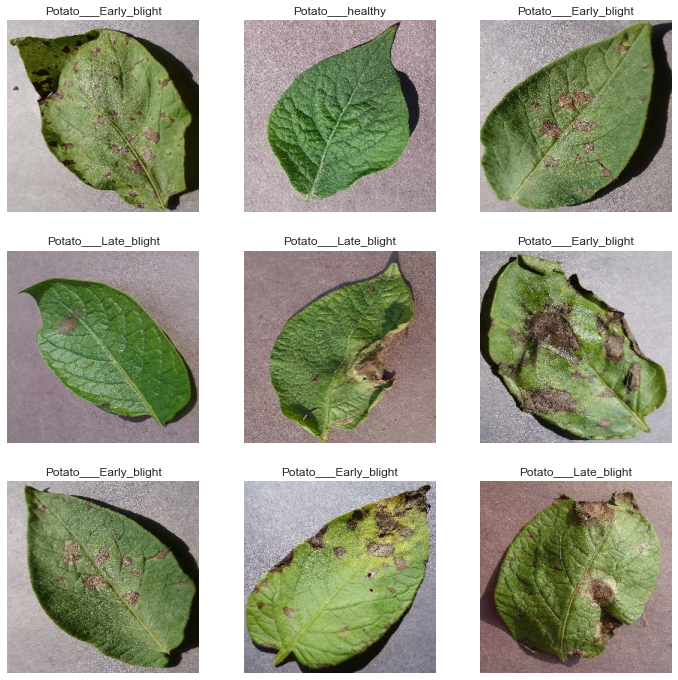

In [193]:
plt.figure(figsize=(12,12))
for images,labels in dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis('off')  

In [133]:
#creating a function to create train,test and validation splits
def ds_partition(data,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_length=10000,seed=25):
    
    train_size = int(len(data)*train_split)
    val_size = int(len(data)*val_split)
    
    if shuffle==True:
        data=data.shuffle(shuffle_length,seed)
    
    train_ds = data.take(train_size)
    val_ds = data.skip(train_size).take(val_size)
    test_ds = data.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [134]:
train_ds , val_ds, test_ds = ds_partition(dataset)

#### Cache, Shuffle, and Prefetch the Dataset to improve overall performance

In [138]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [139]:
#importing necessary libraries for building the model
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D , Dense , Flatten , Dropout , MaxPool2D , Resizing , Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Resizing and Normalization of the data
* Resizing is not necessary since all our images are already been resized to the same size but this is used to resize the images in case of predicting new images
* Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1

In [140]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

* creating data augmentation to increase the data and
* also to improve the accuracy of the model on the new unseen data

In [141]:
#creating data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [142]:
#applying data augmentation on the training data
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

###MODEL ARCHITECTURE

we will be using CONVOLUTION NEURAL NETWORK(CNN) , which is best for image classification task

In [143]:
#building CNN
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = keras.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [144]:
#building the model
model.build(input_shape)

In [145]:
#checking the built model
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_19 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_45 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_45 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_46 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (32, 60, 60, 64)        

In [190]:
#compiling the model using ADAM optimizer , and loss as CATEGORICALCROSSENTROPY since it is a multiclass classification
model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
             )

In [149]:
history = model.fit(train_ds,validation_data=val_ds,batch_size=BATCH_SIZE,epochs=50,verbose=1)

Epoch 1/50
54/54 [==============================] - 153s 3s/step - loss: 0.8876 - accuracy: 0.4812 - val_loss: 0.7662 - val_accuracy: 0.5573
Epoch 2/50
54/54 [==============================] - 149s 3s/step - loss: 0.6404 - accuracy: 0.6984 - val_loss: 0.3945 - val_accuracy: 0.8177
Epoch 3/50
54/54 [==============================] - 146s 3s/step - loss: 0.4974 - accuracy: 0.7811 - val_loss: 0.4551 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 149s 3s/step - loss: 0.4808 - accuracy: 0.7923 - val_loss: 0.3733 - val_accuracy: 0.8490
Epoch 5/50
54/54 [==============================] - 145s 3s/step - loss: 0.3486 - accuracy: 0.8486 - val_loss: 0.2387 - val_accuracy: 0.9167
Epoch 6/50
54/54 [==============================] - 139s 3s/step - loss: 0.2225 - accuracy: 0.9161 - val_loss: 0.2583 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 130s 2s/step - loss: 0.1865 - accuracy: 0.9308 - val_loss: 0.1763 - val_accuracy: 0.9427
Epoch 8/50
54

In [150]:
#evaluating the model on the test data
Testscore = model.evaluate(test_ds)

8/8 [==============================] - 10s 686ms/step - loss: 0.0133 - accuracy: 0.9922


so we have obtained 99% accuracy on our test data which is pretty good

minimum validation loss: 0.02397533319890499


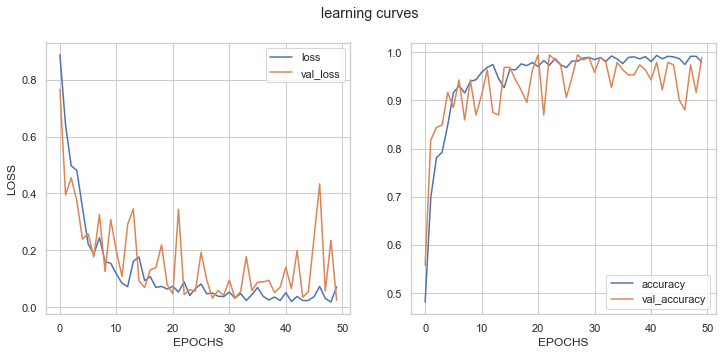

In [194]:
#Interpreting the learning curves to check how well our model performs
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)
history_df.loc[:,['loss','val_loss']].plot(ax=ax)
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
ax = plt.subplot(1,2,2)
history_df.loc[:,['accuracy','val_accuracy']].plot(ax=ax)
plt.xlabel("EPOCHS")
plt.suptitle("learning curves")
print("minimum validation loss:",history_df['val_loss'].min())

Actual class of image is : Potato___Late_blight
predicted class is  Potato___Late_blight
confidence 100.0 %


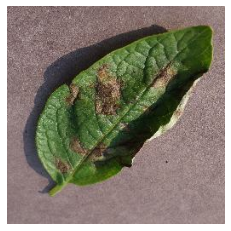

In [196]:
#checking how good our image classifies on a random test data
for images , labels in test_ds.take(1):
    
    image = images[0].numpy().astype("uint8")
    label = labels[0].numpy()
    plt.imshow(image)
    print('Actual class of image is :',classes[label])
    prediction = model.predict(images)
    print("predicted class is ",classes[np.argmax(prediction[0])])
    print('confidence',round(100 * (np.max(prediction[0])), 2),'%')
    plt.axis('off')

In [189]:
#saving the model
model.save("potato_classifier_model.h5")